In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
!pip install pytorch
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
  error: subprocess-exited-with-error
  
  × Running setup.py install for pytorch did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Running setup.py install for pytorch ... error
error: legacy-install-failure

× Encountered error while trying to install package.
╰─> pytorch

note: This is an issue with the package mentioned above, not pip.
hint: See above for output from the failure.
Looking in indexes: ht

In [ ]:
import torch
torch.__version__

'1.13.1+cu116'

In [ ]:
!pip install ipywidgets  
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-kwxgk9h8
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-kwxgk9h8
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.5/344.5 KB 32.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [ ]:
## 파라미터 세팅 
class config: 
  max_len = 70
  batch_size = 32
  warmup_ratio = 0.1
  num_epochs = 5
  max_grad_norm = 1
  log_interval = 200
  learning_rate =  5e-5

In [ ]:
## GPU
device = torch.device("cuda:0")

In [ ]:
 # kobert model, vocab 불러오기 
bertmodel, vocab = get_pytorch_kobert_model(cachedir=".cache")

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


In [ ]:
#kobert tokenizer
tokenizer = get_tokenizer() 
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [ ]:
#Google Drive 연동 
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/NLP/Data/최종학습데이터세트_병합ver_전처리전단계_0116.csv',encoding = 'utf-8')
#하위 카테고리 drop
data.drop('하위 카테고리',axis = 1,inplace = True)
#label encoding
data['카테고리'] = data['카테고리'].replace(['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],[0,1,2,3,4,5,6,7,8,9])

In [ ]:
from sklearn.model_selection import train_test_split

#stratify train-test split

X_data = data['품목명']
y_data = data['카테고리']

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=2023, stratify=y_data)

In [ ]:
# 정규표현식 통해 전처리 이후 train-valid split 위해 다시 합쳐주기 
train_data = pd.DataFrame([ x for x in zip(X_train,y_train)])
train_data.columns = ['품목명','label']

In [ ]:
import re
# 데이터 전처리 
# 괄호(),[],<> 안에 들어가있는 문자들 제거
train_data.replace('\[[^]]*\]', '', regex=True,inplace=True)
train_data.replace('\([^]]*\)', '', regex=True,inplace=True)
train_data.replace('\<[^]]*\>', '', regex=True,inplace=True)

# 특수문자를 띄어쓰기로 대체(특수문자: 영어, 한글, 숫자 제외한 문자들)
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[^A-Za-z0-9가-힣]').sub(' ',x))

# 숫자를 공백(띄어쓰기 없음)으로 대체
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'[0-9]').sub('',x))

# 숫자를 공백으로 대체한 후, 중복값 제거
train_data.drop_duplicates(['품목명'], keep = 'first',ignore_index = True, inplace=True)

# 알파벳 길이가 1인 문자 제거
train_data['품목명']=train_data['품목명'].apply(lambda x: re.compile(r'(?<=\s)([A-Za-z])(?=\s)').sub(' ',x))

In [ ]:
#stratify trian-valid split 
X_train, X_val, y_train, y_val = train_test_split(train_data['품목명'], train_data['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 2023, 
                                                    stratify = train_data['label'])

In [ ]:
#kobert 모델 사용을 위한 BERTDataset class 
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))


In [ ]:
#BERTDataset 클래스에 data를 넣기 위한 데이터 형태 변환 
dataset_train = []
for product,category in zip(X_train,y_train):
  train = []
  train.append(product)
  train.append(str(category))
  dataset_train.append(train)

dataset_valid = []
for product,category in zip(X_val,y_val):
  val = []
  val.append(product)
  val.append(str(category))
  dataset_valid.append(val)

dataset_test = []
for product,category in zip(X_test,y_test):
  test = []
  test.append(product)
  test.append(str(category))
  dataset_test.append(test)

In [ ]:
data_train = BERTDataset(dataset_train, 0, 1, tok, config.max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, config.max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, config.max_len, True, False)

In [ ]:
#torch dataloader
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=config.batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=config.batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=config.batch_size, num_workers=5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  assert self._num_workers == 0


In [ ]:
# 데이터 분포 확인
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number')

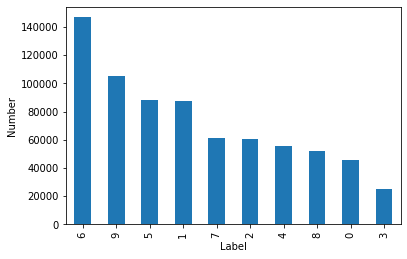

In [ ]:
y_train.value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

Text(0, 0.5, 'Number')

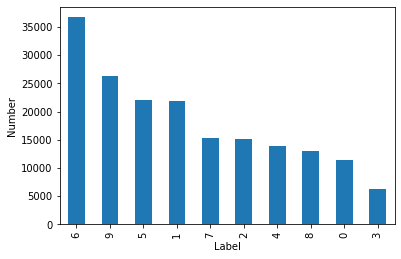

In [ ]:
y_val.value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

Text(0, 0.5, 'Number')

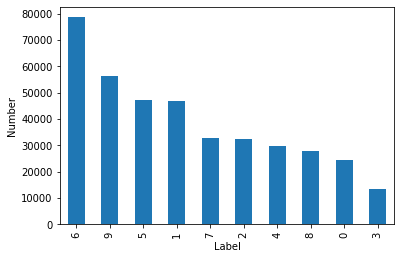

In [ ]:
y_test.value_counts().plot(kind = 'bar')
plt.xlabel("Label")
plt.ylabel("Number")

Stratify split 완료

In [ ]:
#BERTClassifier class 
#num_classes 조정 
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=10,
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [ ]:
model = torch.load('/content/drive/MyDrive/NLP/Models/preprocessing_model.pth')
#model = BERTClassifier(bertmodel, dr_rate=0.5).to(device) 

# optimizer, schedule 조정 
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
#AdamW optimizer 사용. 
optimizer = AdamW(optimizer_grouped_parameters, lr=config.learning_rate)
#multiclass classification이기 때문에 손실함수는 CrossEntropyLoss 사용 
loss_fn = nn.CrossEntropyLoss()

#learning_rate 조절을위한 warmup 정의
t_total = len(train_dataloader) * config.num_epochs
warmup_step = int(t_total * config.warmup_ratio)
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

In [ ]:
#정확도 계산 함수 
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
#모델 학습
for e in range(config.num_epochs):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % config.log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in tqdm(enumerate(valid_dataloader), total=len(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        valid_acc += calc_accuracy(out, label)
    print("epoch {} valid acc {}".format(e+1, valid_acc / (batch_id+1)))

  0%|          | 0/22747 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.08044596016407013 train acc 0.96875
epoch 1 batch id 201 loss 0.011555570177733898 train acc 0.9878731343283582
epoch 1 batch id 401 loss 0.031545426696538925 train acc 0.9880766832917706
epoch 1 batch id 601 loss 0.002696039853617549 train acc 0.988196755407654
epoch 1 batch id 801 loss 0.001746771507896483 train acc 0.9884519350811486
epoch 1 batch id 1001 loss 0.01732539013028145 train acc 0.9890734265734266
epoch 1 batch id 1201 loss 0.01773512177169323 train acc 0.9886032472939217
epoch 1 batch id 1401 loss 0.09985522925853729 train acc 0.9873081727337616
epoch 1 batch id 1601 loss 0.0019264667062088847 train acc 0.9864147407870081
epoch 1 batch id 1801 loss 0.0027070273645222187 train acc 0.9849389228206552
epoch 1 batch id 2001 loss 0.0021999310702085495 train acc 0.9841329335332334
epoch 1 batch id 2201 loss 0.008944484405219555 train acc 0.983459223080418
epoch 1 batch id 2401 loss 0.06700292974710464 train acc 0.9829628279883382
epoch 1 batch id 2601

KeyboardInterrupt: ignored

In [ ]:
#모델 저장
torch.save(model,'/content/drive/MyDrive/NLP/Models/' + 'kobert_model.pth')  # 전체 모델 저장

In [ ]:
def softmax(vals, idx):
    valscpu = vals.cpu().detach().squeeze(0)
    a = 0
    for i in valscpu:
        a += np.exp(i)
    return ((np.exp(valscpu[idx]))/a).item() * 100

def testModel(model, seq):
    cate = ['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아']
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, config.max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    model.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()

    return cate[idx]
    print("상품명 : ",seq)
    print("상품의 카테고리는:", cate[idx])
    print("신뢰도는:", "{:.2f}%".format(softmax(result,idx)))
def testModel2(model, seq):
    cate = ['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아']
    tmp = [seq]
    transform = nlp.data.BERTSentenceTransform(tok, config.max_len, pad=True, pair=False)
    tokenized = transform(tmp)

    model.eval()
    result = model(torch.tensor([tokenized[0]]).to(device), [tokenized[1]], torch.tensor(tokenized[2]).to(device))
    idx = result.argmax().cpu().item()

    return softmax(result,idx)
    print("상품명 : ",seq)
    print("상품의 카테고리는:", cate[idx])
    print("신뢰도는:", "{:.2f}%".format(softmax(result,idx)))

In [ ]:
test_data = pd.DataFrame([ x for x in zip(X_test,y_test)])
test_data.columns = ['품목명','label']

In [ ]:
test_data

,품목명,label
0,비비안 롱 코트 BACT52162,6
1,여성용 MTB 자전거 산악 로드 바퀴큰 MTB자전거 출퇴,1
2,여수새조개 자연산특품 손질 활새조개 샤브샤브 500g 1kg 산지직송 당일조업 채취 택배,2
3,베이직 누빔 굴곡형 라텍스 베개커버,4
4,포스터 스탠드 배너 안내판 입간판 슬림 사각 A3,9
...,...,...
417015,concombre 판다 맥주,0
417016,포인트 무소음 인테리어 소품 벽시계 부엉이 벽걸이시계 I-W4D0F38,4
417017,KD-48,5
417018,20대 캐주얼 핸드폰 책수납 크로스백 남자크로스백,7


In [ ]:
dataset_test = []
for product,category in zip(X_test,y_test):
  test = []
  test.append(product)
  test.append(str(category))
  dataset_test.append(test)
data_test = BERTDataset(dataset_test, 0, 1, tok, config.max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=config.batch_size, num_workers=5)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  assert self._num_workers == 0


In [ ]:
from tqdm import tqdm
from tqdm import tqdm, tqdm_notebook
predictions =[]
with torch.no_grad():
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
    token_ids = token_ids.long().cuda()
    segment_ids = segment_ids.long().cuda()
    valid_length= valid_length
    label = label.long().cuda()
    out = model(token_ids, valid_length, segment_ids)
    _, max_indices = torch.max(out, 1)

    predictions.extend(max_indices.squeeze(0).detach().cpu().numpy())

<ipython-input-29-0ac48365fe5c>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/26064 [00:00<?, ?it/s]

In [ ]:
test_data['predict'] = predictions

In [ ]:
test_data

,품목명,label,predict
0,비비안 롱 코트 BACT52162,6,6
1,여성용 MTB 자전거 산악 로드 바퀴큰 MTB자전거 출퇴,1,1
2,여수새조개 자연산특품 손질 활새조개 샤브샤브 500g 1kg 산지직송 당일조업 채취 택배,2,2
3,베이직 누빔 굴곡형 라텍스 베개커버,4,4
4,포스터 스탠드 배너 안내판 입간판 슬림 사각 A3,9,4
...,...,...,...
417015,concombre 판다 맥주,0,0
417016,포인트 무소음 인테리어 소품 벽시계 부엉이 벽걸이시계 I-W4D0F38,4,4
417017,KD-48,5,5
417018,20대 캐주얼 핸드폰 책수납 크로스백 남자크로스백,7,7


In [ ]:
test_data['label'] = test_data['label'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)
test_data['predict'] = test_data['predict'].replace([0,1,2,3,4,5,6,7,8,9],['생활/건강','스포츠/레저','식품','여가/생활편의', '가구/인테리어', '디지털/가전', '패션의류','패션잡화', '화장품/미용', '출산/육아'],)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

cl_report = classification_report(test_data['predict'],test_data['label'], output_dict = True)
cl_report_df = pd.DataFrame(cl_report).transpose()
cl_report_df = cl_report_df.round(10)
print(cl_report_df)

              precision    recall  f1-score        support
가구/인테리어        0.985576  0.965102  0.975232   32781.000000
디지털/가전         0.978318  0.976534  0.977425   54846.000000
생활/건강          0.945038  0.939235  0.942128   26545.000000
스포츠/레저         0.966881  0.962861  0.964867   49301.000000
식품             0.978184  0.988655  0.983392   34377.000000
여가/생활편의        0.934220  0.952161  0.943106   14528.000000
출산/육아          0.961122  0.963228  0.962174   59338.000000
패션의류           0.987911  0.988046  0.987978   80808.000000
패션잡화           0.978138  0.985992  0.982049   35122.000000
화장품/미용         0.977863  0.980493  0.979176   29374.000000
accuracy       0.973208  0.973208  0.973208       0.973208
macro avg      0.969325  0.970231  0.969753  417020.000000
weighted avg   0.973236  0.973208  0.973205  417020.000000


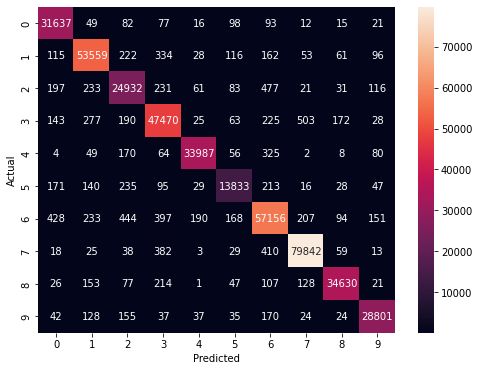

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(test_data['label'], test_data['predict'])
fig, ax = plt.subplots(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()